In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight


Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [5]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [6]:
def loadImages(path_data):
    
    p = '/home/jovyan/DATA_MASTER_PROJECT/IMG_A549_high_con/'
    
    
    
    pa_adr = p + 'ADR_cropped/'
    
    pa_control = p + 'CONTROL_cropped/'
    
    pa_hrh = p + 'HRH_cropped/'
    
    pa_dmso = p + 'DMSO_cropped/'
    
    image_list = []
    
    
       


    for filename in sorted(path_data, key=natural_keys): 
        
        if 'adr' in filename:
            
            im=cv2.imread(pa_adr + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'control' in filename:
            
            im=cv2.imread(pa_control + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'hrh' in filename:
            
            im=cv2.imread(pa_hrh + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'dmso' in filename:
            
            im=cv2.imread(pa_dmso + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)



    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))

    return x_orig

In [7]:
def return_count(x):
    name_wel = []
    for i in sorted(x, key = natural_keys):
        name_wel.append(i.split('_')[0])

    z = sorted(list(set(name_wel)))
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(x, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [8]:
def loadImages_LSTM(path_data,len_t_points):
    

    feat_list = []


    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        feat_list.append(np.load(filename))

    x_orig = np.reshape(feat_list, (len(feat_list),len_t_points, 64))

    return x_orig 

In [9]:
def make_labels(data_set):
    fe = return_count(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [10]:
def make_labels_LSTM(data_set):
    fe = return_count_LSTM(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [11]:
def return_count_LSTM(x):
    name_wel = []
    for _,_,i in os.walk(x):
        for f in i:
            name_wel.append(f.split('_')[2])

    z = sorted(list(set(name_wel)), key=natural_keys)
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(name_wel, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [12]:
def creat_label(y):
    labels = []
    for ix, _ in enumerate(y):
        
        if y[ix][0] == 'adr':
        
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'hrh':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
        
        if y[ix][0] == 'control':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
            
        if y[ix][0] == 'dmso':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
    
    ler = [i for sub in labels for i in sub ]
    
    _, lab= zip(*ler)

    
    return lab

In [13]:
def time_step_acc(tes_data, x):

    results = []            

    x_test = loadImages(tes_data)
    y_test = make_labels(tes_data)
    x_test = resize(x_test)
    x_test = preprocess_input(x_test)

    scores = x.evaluate(x_test, y_test, verbose = 1)
    results.append(scores[1]*100)

    return results

In [14]:
def cv_mean_acc(result_cv, string_well):
    
    l_drug = string_well*3

    acc_mean_cv = []

    for i in result_cv:
        acc_mean_cv.append(np.mean(i))
        
    cv_drug = list(zip(acc_mean_cv, l_drug))
    
    res = sorted(cv_drug, key = lambda x: x[1])
    a , b = zip(*res)
    
    a = list(a)
    
    s = list(np.array_split(a, len(string_well)))
    
    cv_score_acc = []
    
    for ix, i in enumerate(s):
        s1 = list(s[ix])
        
        cv_score_acc.append(np.mean(s1))
        
    return list(zip(cv_score_acc, string_well))

In [15]:
# DATA FOR LSTM PART

p_feat = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/'
train_data = p_feat + 'features_train/*.npy'
val_data = p_feat + 'features_validation/*.npy'
tes_data= p_feat + 'features_test/*.npy'

y_tra_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_train/'
y_tes_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_test/'
y_val_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_validation/'

In [16]:
met = ['F10']
mid = ['D5']
oxy = ['F6']
nap = ['B3']
dip = ['F2']
met_1 = ['B7']
lab = ['D10']
car = ['G2']
mep = ['B11']
nef = ['C10']
tri = ['B2']
dox = ['F8']


cycl = ['C4']
dime =  ['F7']
cypr  = ['G9']
lora = [ 'E5']
doxy = ['D4']
oloa = ['E2']
hydr = ['F5']
orph = ['E7']
cinn = ['B10']
desl = ['F3']
chlo =  ['D2']
trim = ['E9']
mian= ['E8']
fexo= ['B5']
chlo_1 = ['E3']
trip= ['C5']
desi= ['E4']
levo= ['C3']
diphe_1= ['C7']
diphe_2= ['F11']
emed= ['G6']
ceti= ['D11']
trip_1= ['F9']
doxe=['C2']
chlo_2= ['D6']
flun = ['C9']
keto= ['D7']

In [17]:
tot_results_accuracy = []

results_lstm = []

In [18]:
tot_well_adr = [met,mid,oxy,nap,dip,met_1,lab,car,mep,nef,tri,dox]
tot_well_hrh = [cycl, dime, cypr,lora,doxy,oloa,cinn,desl,chlo,trim,mian,fexo,chlo_1,trip,desi,levo,
                
                diphe_1,diphe_2,emed,ceti,trip_1,doxe,chlo_2,flun,keto]

string_well_adr = ['met', 'mid', 'oxy', 'nap', 'dip','met_1','lab','car','mep','nef','tri','dox']
string_well_hrh = ['cycl', 'dime', 'cypr', 'lora', 'doxy','oloa','cinn','desl','chlo','trim','mian','fexo','chlo_1','trip','desi',
                  'levo','diphe_1','diphe_2','emed','ceti','trip_1','doxe','chlo_2','flun','keto']


In [19]:
tot_well = []
string_well = [] 

In [20]:
a = 'ADR' # FOR TEST SET
b = 'HRH' # FOR REST

if a == 'HRH':
    tot_well = tot_well_hrh
    string_well = string_well_hrh
    
if a == 'ADR':
    tot_well = tot_well_adr
    string_well = string_well_adr
    

In [21]:
rand = list(np.random.randint(1,1000,3))

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 950.328125 steps, validate for 249.0546875 steps
Epoch 1/300
951/950 [==============================] - 32s 33ms/step - loss: 0.6151 - accuracy: 0.6772 - val_loss: 0.6088 - val_accuracy: 0.6956
Epoch 2/300
951/950 [==============================] - 27s 29ms/step - loss: 0.5803 - accuracy: 0.7028 - val_loss: 0.6091 - val_accuracy: 0.6955
Epoch 3/300
951/950 [==============================] - 27s 28ms/step - loss: 0.5678 - accuracy: 0.7093 - val_loss: 0.6105 - val_accuracy: 0.6933
Epoch 4/300
951/950 [==============================] - 28s 29ms/step - loss: 0.5586 - accuracy: 0.7147 - val_loss: 0.6086 - val_accuracy: 0.6936
Epoch 5/300
951/950 [==============================] - 28s 29ms/step - loss: 0.5505 - accuracy: 0.7202 - val_loss: 0.6156 - val_accuracy: 0.6869
Epoch 6/300
951/950 [==============================] - 27s 29ms/step - loss: 0.5434 - accuracy: 0.7247 - val_loss: 0.6145 - val_accuracy: 0.6905
Epoch 7/300
951/950 [

1it [21:07, 1267.76s/it]
100%|██████████| 2/2 [00:05<00:00,  2.61s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 942.671875 steps, validate for 244.7265625 steps
Epoch 1/300
943/942 [==============================] - 28s 30ms/step - loss: 0.6093 - accuracy: 0.6765 - val_loss: 0.5980 - val_accuracy: 0.7019
Epoch 2/300
943/942 [==============================] - 27s 28ms/step - loss: 0.5717 - accuracy: 0.7113 - val_loss: 0.5948 - val_accuracy: 0.7074
Epoch 3/300
943/942 [==============================] - 27s 28ms/step - loss: 0.5588 - accuracy: 0.7181 - val_loss: 0.5921 - val_accuracy: 0.7135
Epoch 4/300
943/942 [==============================] - 26s 28ms/step - loss: 0.5492 - accuracy: 0.7237 - val_loss: 0.5967 - val_accuracy: 0.7094
Epoch 5/300
943/942 [==============================] - 27s 28ms/step - loss: 0.5410 - accuracy: 0.7285 - val_loss: 0.6049 - val_accuracy: 0.7019
Epoch 6/300
943/942 [==============================] - 26s 28ms/step - loss: 0.5335 - accuracy: 0.7325 - val_loss: 0.6055 - val_accuracy: 0.7026
Epoch 00006: early st

2it [42:49, 1277.84s/it]
100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 948.34375 steps, validate for 247.2421875 steps
Epoch 1/300
949/948 [==============================] - 27s 28ms/step - loss: 0.6182 - accuracy: 0.6695 - val_loss: 0.6111 - val_accuracy: 0.7017
Epoch 2/300
949/948 [==============================] - 26s 28ms/step - loss: 0.5789 - accuracy: 0.7069 - val_loss: 0.6047 - val_accuracy: 0.7036
Epoch 3/300
949/948 [==============================] - 27s 28ms/step - loss: 0.5670 - accuracy: 0.7138 - val_loss: 0.6100 - val_accuracy: 0.6997
Epoch 4/300
949/948 [==============================] - 27s 28ms/step - loss: 0.5583 - accuracy: 0.7186 - val_loss: 0.6085 - val_accuracy: 0.7015
Epoch 5/300
949/948 [==============================] - 26s 28ms/step - loss: 0.5509 - accuracy: 0.7220 - val_loss: 0.6106 - val_accuracy: 0.6996
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 948 steps, validate for 247 steps
Epoch 1/300
948/948 [========================

3it [1:02:02, 1240.39s/it]
100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 941.7265625 steps, validate for 247.3046875 steps
Epoch 1/300
942/941 [==============================] - 28s 29ms/step - loss: 0.6095 - accuracy: 0.6711 - val_loss: 0.6032 - val_accuracy: 0.7034
Epoch 2/300
942/941 [==============================] - 27s 28ms/step - loss: 0.5690 - accuracy: 0.7101 - val_loss: 0.6001 - val_accuracy: 0.7069
Epoch 3/300
942/941 [==============================] - 27s 29ms/step - loss: 0.5574 - accuracy: 0.7167 - val_loss: 0.5970 - val_accuracy: 0.7079
Epoch 4/300
942/941 [==============================] - 27s 29ms/step - loss: 0.5483 - accuracy: 0.7221 - val_loss: 0.6063 - val_accuracy: 0.6992
Epoch 5/300
942/941 [==============================] - 26s 28ms/step - loss: 0.5406 - accuracy: 0.7269 - val_loss: 0.6096 - val_accuracy: 0.6970
Epoch 6/300
942/941 [==============================] - 26s 28ms/step - loss: 0.5334 - accuracy: 0.7320 - val_loss: 0.6003 - val_accuracy: 0.7087
Epoch 00006: early s

4it [1:22:48, 1242.30s/it]
100%|██████████| 2/2 [00:05<00:00,  2.77s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 950.609375 steps, validate for 249.2265625 steps
Epoch 1/300
951/950 [==============================] - 28s 29ms/step - loss: 0.6200 - accuracy: 0.6657 - val_loss: 0.6024 - val_accuracy: 0.7000
Epoch 2/300
951/950 [==============================] - 26s 27ms/step - loss: 0.5789 - accuracy: 0.7025 - val_loss: 0.6039 - val_accuracy: 0.6967
Epoch 3/300
951/950 [==============================] - 26s 28ms/step - loss: 0.5665 - accuracy: 0.7097 - val_loss: 0.6102 - val_accuracy: 0.6904
Epoch 4/300
951/950 [==============================] - 27s 28ms/step - loss: 0.5575 - accuracy: 0.7149 - val_loss: 0.6086 - val_accuracy: 0.6923
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 950 steps, validate for 249 steps
Epoch 1/300
950/950 [==============================] - 62s 66ms/step - loss: 0.5422 - accuracy: 0.7261 - val_loss: 0.6174 - val_accuracy: 0.6773
Epoch 2/300
950/950 [=======================

5it [1:42:47, 1229.08s/it]
100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 943.109375 steps, validate for 245.7890625 steps
Epoch 1/300
944/943 [==============================] - 28s 29ms/step - loss: 0.6143 - accuracy: 0.6766 - val_loss: 0.6023 - val_accuracy: 0.7012
Epoch 2/300
944/943 [==============================] - 26s 28ms/step - loss: 0.5776 - accuracy: 0.7076 - val_loss: 0.6006 - val_accuracy: 0.7020
Epoch 3/300
944/943 [==============================] - 26s 28ms/step - loss: 0.5648 - accuracy: 0.7153 - val_loss: 0.5998 - val_accuracy: 0.7022
Epoch 4/300
944/943 [==============================] - 26s 28ms/step - loss: 0.5553 - accuracy: 0.7205 - val_loss: 0.6011 - val_accuracy: 0.7034
Epoch 5/300
944/943 [==============================] - 26s 28ms/step - loss: 0.5472 - accuracy: 0.7257 - val_loss: 0.6001 - val_accuracy: 0.7053
Epoch 6/300
944/943 [==============================] - 26s 28ms/step - loss: 0.5402 - accuracy: 0.7300 - val_loss: 0.6047 - val_accuracy: 0.6985
Epoch 00006: early st

6it [2:02:17, 1211.45s/it]
100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 945.625 steps, validate for 246.3359375 steps
Epoch 1/300
946/945 [==============================] - 27s 29ms/step - loss: 0.6132 - accuracy: 0.6808 - val_loss: 0.6048 - val_accuracy: 0.7029
Epoch 2/300
946/945 [==============================] - 27s 28ms/step - loss: 0.5812 - accuracy: 0.7053 - val_loss: 0.6038 - val_accuracy: 0.7006
Epoch 3/300
946/945 [==============================] - 26s 28ms/step - loss: 0.5695 - accuracy: 0.7114 - val_loss: 0.6051 - val_accuracy: 0.7011
Epoch 4/300
946/945 [==============================] - 26s 28ms/step - loss: 0.5607 - accuracy: 0.7157 - val_loss: 0.6067 - val_accuracy: 0.6991
Epoch 5/300
946/945 [==============================] - 26s 27ms/step - loss: 0.5529 - accuracy: 0.7204 - val_loss: 0.6112 - val_accuracy: 0.6959
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 945 steps, validate for 246 steps
Epoch 1/300
945/945 [==========================

7it [2:22:34, 1213.13s/it]
100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 952.1171875 steps, validate for 251.6484375 steps
Epoch 1/300
953/952 [==============================] - 28s 29ms/step - loss: 0.6220 - accuracy: 0.6612 - val_loss: 0.6173 - val_accuracy: 0.6906
Epoch 2/300
953/952 [==============================] - 26s 28ms/step - loss: 0.5786 - accuracy: 0.7043 - val_loss: 0.6147 - val_accuracy: 0.6912
Epoch 3/300
953/952 [==============================] - 27s 28ms/step - loss: 0.5671 - accuracy: 0.7104 - val_loss: 0.6134 - val_accuracy: 0.6942
Epoch 4/300
953/952 [==============================] - 27s 28ms/step - loss: 0.5580 - accuracy: 0.7153 - val_loss: 0.6213 - val_accuracy: 0.6885
Epoch 5/300
953/952 [==============================] - 27s 28ms/step - loss: 0.5500 - accuracy: 0.7203 - val_loss: 0.6164 - val_accuracy: 0.6917
Epoch 6/300
953/952 [==============================] - 26s 28ms/step - loss: 0.5428 - accuracy: 0.7248 - val_loss: 0.6255 - val_accuracy: 0.6856
Epoch 00006: early s

8it [2:43:13, 1220.86s/it]
100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 934.09375 steps, validate for 248.4296875 steps
Epoch 1/300
935/934 [==============================] - 27s 29ms/step - loss: 0.5931 - accuracy: 0.6959 - val_loss: 0.5964 - val_accuracy: 0.7048
Epoch 2/300
935/934 [==============================] - 26s 27ms/step - loss: 0.5622 - accuracy: 0.7172 - val_loss: 0.6007 - val_accuracy: 0.7019
Epoch 3/300
935/934 [==============================] - 26s 27ms/step - loss: 0.5499 - accuracy: 0.7238 - val_loss: 0.5960 - val_accuracy: 0.7041
Epoch 4/300
935/934 [==============================] - 26s 28ms/step - loss: 0.5401 - accuracy: 0.7299 - val_loss: 0.6013 - val_accuracy: 0.7012
Epoch 5/300
935/934 [==============================] - 26s 28ms/step - loss: 0.5315 - accuracy: 0.7347 - val_loss: 0.6036 - val_accuracy: 0.7031
Epoch 6/300
935/934 [==============================] - 26s 28ms/step - loss: 0.5240 - accuracy: 0.7394 - val_loss: 0.6090 - val_accuracy: 0.6978
Epoch 00006: early sto

9it [3:02:49, 1207.59s/it]
100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 937.0546875 steps, validate for 244.7734375 steps
Epoch 1/300
938/937 [==============================] - 27s 29ms/step - loss: 0.6173 - accuracy: 0.6728 - val_loss: 0.6123 - val_accuracy: 0.7025
Epoch 2/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5764 - accuracy: 0.7117 - val_loss: 0.6053 - val_accuracy: 0.7033
Epoch 3/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5640 - accuracy: 0.7182 - val_loss: 0.6030 - val_accuracy: 0.7066
Epoch 4/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5547 - accuracy: 0.7222 - val_loss: 0.6101 - val_accuracy: 0.7049
Epoch 5/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5466 - accuracy: 0.7267 - val_loss: 0.6070 - val_accuracy: 0.7063
Epoch 6/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5389 - accuracy: 0.7306 - val_loss: 0.6118 - val_accuracy: 0.7023
Epoch 00006: early s

10it [3:23:12, 1212.14s/it]
100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 942.015625 steps, validate for 244.1328125 steps
Epoch 1/300
943/942 [==============================] - 27s 29ms/step - loss: 0.6168 - accuracy: 0.6764 - val_loss: 0.6043 - val_accuracy: 0.7081
Epoch 2/300
943/942 [==============================] - 26s 28ms/step - loss: 0.5812 - accuracy: 0.7076 - val_loss: 0.6005 - val_accuracy: 0.7055
Epoch 3/300
943/942 [==============================] - 26s 28ms/step - loss: 0.5694 - accuracy: 0.7134 - val_loss: 0.6038 - val_accuracy: 0.7009
Epoch 4/300
943/942 [==============================] - 26s 28ms/step - loss: 0.5603 - accuracy: 0.7183 - val_loss: 0.6053 - val_accuracy: 0.7010
Epoch 5/300
943/942 [==============================] - 26s 28ms/step - loss: 0.5523 - accuracy: 0.7227 - val_loss: 0.6061 - val_accuracy: 0.6986
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 942 steps, validate for 244 steps
Epoch 1/300
942/942 [=======================

11it [3:43:15, 1209.42s/it]
100%|██████████| 2/2 [00:05<00:00,  2.63s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 940.4296875 steps, validate for 249.421875 steps
Epoch 1/300
941/940 [==============================] - 27s 29ms/step - loss: 0.6148 - accuracy: 0.6714 - val_loss: 0.6010 - val_accuracy: 0.7037
Epoch 2/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5760 - accuracy: 0.7076 - val_loss: 0.6021 - val_accuracy: 0.7080
Epoch 3/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5636 - accuracy: 0.7145 - val_loss: 0.6007 - val_accuracy: 0.7090
Epoch 4/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5545 - accuracy: 0.7197 - val_loss: 0.6029 - val_accuracy: 0.7063
Epoch 5/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5468 - accuracy: 0.7238 - val_loss: 0.6078 - val_accuracy: 0.7032
Epoch 6/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5397 - accuracy: 0.7280 - val_loss: 0.6098 - val_accuracy: 0.7016
Epoch 00006: early st

12it [4:03:49, 1219.17s/it]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 966.296875 steps, validate for 233.0859375 steps
Epoch 1/300
967/966 [==============================] - 28s 28ms/step - loss: 0.6107 - accuracy: 0.6819 - val_loss: 0.6176 - val_accuracy: 0.6810
Epoch 2/300
967/966 [==============================] - 26s 27ms/step - loss: 0.5802 - accuracy: 0.7043 - val_loss: 0.6189 - val_accuracy: 0.6773
Epoch 3/300
967/966 [==============================] - 26s 27ms/step - loss: 0.5689 - accuracy: 0.7114 - val_loss: 0.6227 - val_accuracy: 0.6756
Epoch 4/300
967/966 [==============================] - 26s 27ms/step - loss: 0.5602 - accuracy: 0.7162 - val_loss: 0.6249 - val_accuracy: 0.6721
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 966 steps, validate for 233 steps
Epoch 1/300
966/966 [==============================] - 62s 65ms/step - loss: 0.5447 - accuracy: 0.7255 - val_loss: 0.6334 - val_accuracy: 0.6691
Epoch 2/300
966/966 [=======================

1it [18:48, 1129.00s/it]
100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 955.9765625 steps, validate for 231.421875 steps
Epoch 1/300
956/955 [==============================] - 27s 29ms/step - loss: 0.5973 - accuracy: 0.6946 - val_loss: 0.6211 - val_accuracy: 0.6837
Epoch 2/300
956/955 [==============================] - 26s 27ms/step - loss: 0.5630 - accuracy: 0.7180 - val_loss: 0.6158 - val_accuracy: 0.6880
Epoch 3/300
956/955 [==============================] - 26s 27ms/step - loss: 0.5502 - accuracy: 0.7254 - val_loss: 0.6246 - val_accuracy: 0.6853
Epoch 4/300
956/955 [==============================] - 26s 28ms/step - loss: 0.5408 - accuracy: 0.7315 - val_loss: 0.6272 - val_accuracy: 0.6773
Epoch 5/300
956/955 [==============================] - 26s 28ms/step - loss: 0.5327 - accuracy: 0.7364 - val_loss: 0.6291 - val_accuracy: 0.6815
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 955 steps, validate for 231 steps
Epoch 1/300
955/955 [=======================

2it [37:58, 1135.03s/it]
100%|██████████| 2/2 [00:05<00:00,  2.64s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 965.15625 steps, validate for 230.4296875 steps
Epoch 1/300
966/965 [==============================] - 27s 28ms/step - loss: 0.6209 - accuracy: 0.6658 - val_loss: 0.6223 - val_accuracy: 0.6863
Epoch 2/300
966/965 [==============================] - 26s 27ms/step - loss: 0.5771 - accuracy: 0.7102 - val_loss: 0.6184 - val_accuracy: 0.6825
Epoch 3/300
966/965 [==============================] - 27s 27ms/step - loss: 0.5646 - accuracy: 0.7166 - val_loss: 0.6199 - val_accuracy: 0.6779
Epoch 4/300
966/965 [==============================] - 26s 27ms/step - loss: 0.5553 - accuracy: 0.7220 - val_loss: 0.6159 - val_accuracy: 0.6807
Epoch 5/300
966/965 [==============================] - 26s 27ms/step - loss: 0.5472 - accuracy: 0.7272 - val_loss: 0.6226 - val_accuracy: 0.6783
Epoch 6/300
966/965 [==============================] - 26s 27ms/step - loss: 0.5400 - accuracy: 0.7313 - val_loss: 0.6292 - val_accuracy: 0.6749
Epoch 7/300
966/965 [=

3it [58:01, 1155.40s/it]
100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 951.515625 steps, validate for 237.515625 steps
Epoch 1/300
952/951 [==============================] - 28s 29ms/step - loss: 0.5903 - accuracy: 0.7010 - val_loss: 0.6174 - val_accuracy: 0.6777
Epoch 2/300
952/951 [==============================] - 26s 27ms/step - loss: 0.5610 - accuracy: 0.7195 - val_loss: 0.6192 - val_accuracy: 0.6729
Epoch 3/300
952/951 [==============================] - 26s 28ms/step - loss: 0.5503 - accuracy: 0.7261 - val_loss: 0.6244 - val_accuracy: 0.6717
Epoch 4/300
952/951 [==============================] - 26s 27ms/step - loss: 0.5422 - accuracy: 0.7308 - val_loss: 0.6283 - val_accuracy: 0.6689
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 951 steps, validate for 237 steps
Epoch 1/300
951/951 [==============================] - 61s 65ms/step - loss: 0.5274 - accuracy: 0.7411 - val_loss: 0.6287 - val_accuracy: 0.6656
Epoch 2/300
951/951 [========================

4it [1:16:42, 1145.37s/it]
100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 963.8984375 steps, validate for 235.9375 steps
Epoch 1/300
964/963 [==============================] - 28s 29ms/step - loss: 0.6097 - accuracy: 0.6810 - val_loss: 0.6210 - val_accuracy: 0.6726
Epoch 2/300
964/963 [==============================] - 26s 27ms/step - loss: 0.5739 - accuracy: 0.7097 - val_loss: 0.6231 - val_accuracy: 0.6721
Epoch 3/300
964/963 [==============================] - 26s 27ms/step - loss: 0.5608 - accuracy: 0.7173 - val_loss: 0.6249 - val_accuracy: 0.6735
Epoch 4/300
964/963 [==============================] - 26s 27ms/step - loss: 0.5510 - accuracy: 0.7229 - val_loss: 0.6264 - val_accuracy: 0.6721
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 963 steps, validate for 235 steps
Epoch 1/300
963/963 [==============================] - 63s 65ms/step - loss: 0.5345 - accuracy: 0.7332 - val_loss: 0.6288 - val_accuracy: 0.6634
Epoch 2/300
963/963 [=========================

5it [1:35:33, 1141.00s/it]
100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 957.7265625 steps, validate for 231.171875 steps
Epoch 1/300
958/957 [==============================] - 27s 28ms/step - loss: 0.6519 - accuracy: 0.6341 - val_loss: 0.6212 - val_accuracy: 0.6825
Epoch 2/300
958/957 [==============================] - 26s 28ms/step - loss: 0.5732 - accuracy: 0.7130 - val_loss: 0.6177 - val_accuracy: 0.6835
Epoch 3/300
958/957 [==============================] - 26s 27ms/step - loss: 0.5589 - accuracy: 0.7208 - val_loss: 0.6161 - val_accuracy: 0.6887
Epoch 4/300
958/957 [==============================] - 26s 27ms/step - loss: 0.5488 - accuracy: 0.7266 - val_loss: 0.6241 - val_accuracy: 0.6782
Epoch 5/300
958/957 [==============================] - 26s 27ms/step - loss: 0.5403 - accuracy: 0.7318 - val_loss: 0.6221 - val_accuracy: 0.6799
Epoch 6/300
958/957 [==============================] - 26s 28ms/step - loss: 0.5327 - accuracy: 0.7365 - val_loss: 0.6276 - val_accuracy: 0.6799
Epoch 00006: early st

6it [1:55:59, 1166.30s/it]
100%|██████████| 2/2 [00:05<00:00,  2.71s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 961.7265625 steps, validate for 230.234375 steps
Epoch 1/300
962/961 [==============================] - 27s 28ms/step - loss: 0.6148 - accuracy: 0.6835 - val_loss: 0.6235 - val_accuracy: 0.6856
Epoch 2/300
962/961 [==============================] - 26s 27ms/step - loss: 0.5812 - accuracy: 0.7078 - val_loss: 0.6258 - val_accuracy: 0.6829
Epoch 3/300
962/961 [==============================] - 26s 27ms/step - loss: 0.5682 - accuracy: 0.7151 - val_loss: 0.6205 - val_accuracy: 0.6846
Epoch 4/300
962/961 [==============================] - 26s 27ms/step - loss: 0.5588 - accuracy: 0.7193 - val_loss: 0.6265 - val_accuracy: 0.6793
Epoch 5/300
962/961 [==============================] - 26s 27ms/step - loss: 0.5507 - accuracy: 0.7236 - val_loss: 0.6254 - val_accuracy: 0.6804
Epoch 6/300
962/961 [==============================] - 26s 27ms/step - loss: 0.5433 - accuracy: 0.7281 - val_loss: 0.6321 - val_accuracy: 0.6742
Epoch 00006: early st

7it [2:18:32, 1222.51s/it]
100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 972.640625 steps, validate for 231.125 steps
Epoch 1/300
973/972 [==============================] - 28s 29ms/step - loss: 0.6356 - accuracy: 0.6478 - val_loss: 0.6206 - val_accuracy: 0.6755
Epoch 2/300
973/972 [==============================] - 26s 27ms/step - loss: 0.5815 - accuracy: 0.7054 - val_loss: 0.6152 - val_accuracy: 0.6808
Epoch 3/300
973/972 [==============================] - 27s 28ms/step - loss: 0.5691 - accuracy: 0.7124 - val_loss: 0.6169 - val_accuracy: 0.6796
Epoch 4/300
973/972 [==============================] - 27s 28ms/step - loss: 0.5600 - accuracy: 0.7181 - val_loss: 0.6144 - val_accuracy: 0.6800
Epoch 5/300
973/972 [==============================] - 27s 28ms/step - loss: 0.5522 - accuracy: 0.7229 - val_loss: 0.6173 - val_accuracy: 0.6789
Epoch 6/300
973/972 [==============================] - 27s 28ms/step - loss: 0.5449 - accuracy: 0.7268 - val_loss: 0.6219 - val_accuracy: 0.6763
Epoch 7/300
973/972 [====

8it [2:38:44, 1219.15s/it]
100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 953.2578125 steps, validate for 229.265625 steps
Epoch 1/300
954/953 [==============================] - 27s 28ms/step - loss: 0.5987 - accuracy: 0.6903 - val_loss: 0.6019 - val_accuracy: 0.6936
Epoch 2/300
954/953 [==============================] - 26s 27ms/step - loss: 0.5591 - accuracy: 0.7233 - val_loss: 0.6006 - val_accuracy: 0.6918
Epoch 3/300
954/953 [==============================] - 26s 27ms/step - loss: 0.5468 - accuracy: 0.7312 - val_loss: 0.6008 - val_accuracy: 0.6896
Epoch 4/300
954/953 [==============================] - 26s 28ms/step - loss: 0.5377 - accuracy: 0.7362 - val_loss: 0.6074 - val_accuracy: 0.6865
Epoch 5/300
954/953 [==============================] - 26s 27ms/step - loss: 0.5295 - accuracy: 0.7406 - val_loss: 0.6044 - val_accuracy: 0.6855
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 953 steps, validate for 229 steps
Epoch 1/300
953/953 [=======================

9it [3:00:43, 1249.30s/it]
100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 953.6796875 steps, validate for 228.1484375 steps
Epoch 1/300
954/953 [==============================] - 27s 28ms/step - loss: 0.6103 - accuracy: 0.6830 - val_loss: 0.6307 - val_accuracy: 0.6851
Epoch 2/300
954/953 [==============================] - 26s 27ms/step - loss: 0.5712 - accuracy: 0.7181 - val_loss: 0.6315 - val_accuracy: 0.6780
Epoch 3/300
954/953 [==============================] - 26s 27ms/step - loss: 0.5588 - accuracy: 0.7238 - val_loss: 0.6268 - val_accuracy: 0.6799
Epoch 4/300
954/953 [==============================] - 26s 27ms/step - loss: 0.5495 - accuracy: 0.7291 - val_loss: 0.6286 - val_accuracy: 0.6790
Epoch 5/300
954/953 [==============================] - 26s 28ms/step - loss: 0.5415 - accuracy: 0.7335 - val_loss: 0.6315 - val_accuracy: 0.6741
Epoch 6/300
954/953 [==============================] - 26s 28ms/step - loss: 0.5341 - accuracy: 0.7384 - val_loss: 0.6392 - val_accuracy: 0.6693
Epoch 00006: early s

10it [3:20:08, 1223.79s/it]
100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 957.875 steps, validate for 228.2734375 steps
Epoch 1/300
958/957 [==============================] - 28s 29ms/step - loss: 0.6113 - accuracy: 0.6820 - val_loss: 0.6171 - val_accuracy: 0.6923
Epoch 2/300
958/957 [==============================] - 26s 27ms/step - loss: 0.5739 - accuracy: 0.7135 - val_loss: 0.6110 - val_accuracy: 0.6925
Epoch 3/300
958/957 [==============================] - 26s 27ms/step - loss: 0.5619 - accuracy: 0.7208 - val_loss: 0.6185 - val_accuracy: 0.6887
Epoch 4/300
958/957 [==============================] - 26s 27ms/step - loss: 0.5530 - accuracy: 0.7258 - val_loss: 0.6200 - val_accuracy: 0.6849
Epoch 5/300
958/957 [==============================] - 26s 27ms/step - loss: 0.5453 - accuracy: 0.7307 - val_loss: 0.6231 - val_accuracy: 0.6848
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 957 steps, validate for 228 steps
Epoch 1/300
957/957 [==========================

11it [3:39:23, 1203.42s/it]
100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 962.625 steps, validate for 227.2265625 steps
Epoch 1/300
963/962 [==============================] - 27s 28ms/step - loss: 0.6089 - accuracy: 0.6846 - val_loss: 0.5985 - val_accuracy: 0.7012
Epoch 2/300
963/962 [==============================] - 26s 27ms/step - loss: 0.5756 - accuracy: 0.7089 - val_loss: 0.5970 - val_accuracy: 0.6980
Epoch 3/300
963/962 [==============================] - 27s 28ms/step - loss: 0.5628 - accuracy: 0.7161 - val_loss: 0.6011 - val_accuracy: 0.6946
Epoch 4/300
963/962 [==============================] - 26s 27ms/step - loss: 0.5535 - accuracy: 0.7216 - val_loss: 0.5994 - val_accuracy: 0.6944
Epoch 5/300
963/962 [==============================] - 26s 27ms/step - loss: 0.5459 - accuracy: 0.7262 - val_loss: 0.6023 - val_accuracy: 0.6968
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 962 steps, validate for 227 steps
Epoch 1/300
962/962 [==========================

12it [3:59:38, 1198.18s/it]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:05<00:00,  2.81s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 946.4765625 steps, validate for 252.90625 steps
Epoch 1/300
947/946 [==============================] - 28s 29ms/step - loss: 0.6330 - accuracy: 0.6528 - val_loss: 0.6379 - val_accuracy: 0.6669
Epoch 2/300
947/946 [==============================] - 27s 28ms/step - loss: 0.5776 - accuracy: 0.7068 - val_loss: 0.6411 - val_accuracy: 0.6710
Epoch 3/300
947/946 [==============================] - 27s 28ms/step - loss: 0.5656 - accuracy: 0.7128 - val_loss: 0.6384 - val_accuracy: 0.6728
Epoch 4/300
947/946 [==============================] - 26s 28ms/step - loss: 0.5569 - accuracy: 0.7173 - val_loss: 0.6462 - val_accuracy: 0.6709
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 946 steps, validate for 252 steps
Epoch 1/300
946/946 [==============================] - 61s 65ms/step - loss: 0.5420 - accuracy: 0.7265 - val_loss: 0.6463 - val_accuracy: 0.6733
Epoch 2/300
946/946 [========================

1it [18:31, 1111.30s/it]
100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 937.5703125 steps, validate for 249.828125 steps
Epoch 1/300
938/937 [==============================] - 27s 29ms/step - loss: 0.6180 - accuracy: 0.6636 - val_loss: 0.6285 - val_accuracy: 0.6777
Epoch 2/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5649 - accuracy: 0.7165 - val_loss: 0.6239 - val_accuracy: 0.6797
Epoch 3/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5527 - accuracy: 0.7237 - val_loss: 0.6256 - val_accuracy: 0.6824
Epoch 4/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5440 - accuracy: 0.7288 - val_loss: 0.6269 - val_accuracy: 0.6818
Epoch 5/300
938/937 [==============================] - 26s 28ms/step - loss: 0.5364 - accuracy: 0.7327 - val_loss: 0.6292 - val_accuracy: 0.6823
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 937 steps, validate for 249 steps
Epoch 1/300
937/937 [=======================

2it [37:43, 1123.49s/it]
100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 944.828125 steps, validate for 250.7578125 steps
Epoch 1/300
945/944 [==============================] - 28s 30ms/step - loss: 0.6265 - accuracy: 0.6552 - val_loss: 0.6322 - val_accuracy: 0.6799
Epoch 2/300
945/944 [==============================] - 27s 28ms/step - loss: 0.5734 - accuracy: 0.7106 - val_loss: 0.6307 - val_accuracy: 0.6791
Epoch 3/300
945/944 [==============================] - 26s 28ms/step - loss: 0.5614 - accuracy: 0.7178 - val_loss: 0.6330 - val_accuracy: 0.6777
Epoch 4/300
945/944 [==============================] - 26s 28ms/step - loss: 0.5528 - accuracy: 0.7226 - val_loss: 0.6343 - val_accuracy: 0.6770
Epoch 5/300
945/944 [==============================] - 26s 28ms/step - loss: 0.5452 - accuracy: 0.7264 - val_loss: 0.6408 - val_accuracy: 0.6785
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 944 steps, validate for 250 steps
Epoch 1/300
944/944 [=======================

3it [56:48, 1129.97s/it]
100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 938.8984375 steps, validate for 250.1328125 steps
Epoch 1/300
939/938 [==============================] - 27s 29ms/step - loss: 0.5962 - accuracy: 0.6912 - val_loss: 0.6259 - val_accuracy: 0.6871
Epoch 2/300
939/938 [==============================] - 26s 28ms/step - loss: 0.5654 - accuracy: 0.7145 - val_loss: 0.6207 - val_accuracy: 0.6884
Epoch 3/300
939/938 [==============================] - 27s 28ms/step - loss: 0.5541 - accuracy: 0.7216 - val_loss: 0.6248 - val_accuracy: 0.6857
Epoch 4/300
939/938 [==============================] - 26s 28ms/step - loss: 0.5450 - accuracy: 0.7271 - val_loss: 0.6214 - val_accuracy: 0.6867
Epoch 5/300
939/938 [==============================] - 26s 28ms/step - loss: 0.5375 - accuracy: 0.7315 - val_loss: 0.6291 - val_accuracy: 0.6838
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 938 steps, validate for 250 steps
Epoch 1/300
938/938 [======================

4it [1:15:59, 1136.34s/it]
100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 949.4296875 steps, validate for 250.40625 steps
Epoch 1/300
950/949 [==============================] - 27s 29ms/step - loss: 0.6034 - accuracy: 0.6896 - val_loss: 0.6231 - val_accuracy: 0.6821
Epoch 2/300
950/949 [==============================] - 27s 28ms/step - loss: 0.5727 - accuracy: 0.7078 - val_loss: 0.6273 - val_accuracy: 0.6812
Epoch 3/300
950/949 [==============================] - 27s 28ms/step - loss: 0.5614 - accuracy: 0.7143 - val_loss: 0.6280 - val_accuracy: 0.6807
Epoch 4/300
950/949 [==============================] - 27s 28ms/step - loss: 0.5528 - accuracy: 0.7197 - val_loss: 0.6283 - val_accuracy: 0.6811
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 949 steps, validate for 250 steps
Epoch 1/300
949/949 [==============================] - 62s 66ms/step - loss: 0.5372 - accuracy: 0.7282 - val_loss: 0.6362 - val_accuracy: 0.6774
Epoch 2/300
949/949 [========================

5it [1:34:44, 1133.05s/it]
100%|██████████| 2/2 [00:05<00:00,  2.83s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 940.8046875 steps, validate for 248.09375 steps
Epoch 1/300
941/940 [==============================] - 28s 29ms/step - loss: 0.6059 - accuracy: 0.6830 - val_loss: 0.6356 - val_accuracy: 0.6872
Epoch 2/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5692 - accuracy: 0.7131 - val_loss: 0.6294 - val_accuracy: 0.6874
Epoch 3/300
941/940 [==============================] - 27s 28ms/step - loss: 0.5574 - accuracy: 0.7204 - val_loss: 0.6281 - val_accuracy: 0.6856
Epoch 4/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5484 - accuracy: 0.7249 - val_loss: 0.6314 - val_accuracy: 0.6848
Epoch 5/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5409 - accuracy: 0.7292 - val_loss: 0.6312 - val_accuracy: 0.6848
Epoch 6/300
941/940 [==============================] - 26s 28ms/step - loss: 0.5339 - accuracy: 0.7333 - val_loss: 0.6393 - val_accuracy: 0.6845
Epoch 00006: early sto

6it [1:54:12, 1143.28s/it]
100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 939.28125 steps, validate for 252.6796875 steps
Epoch 1/300
940/939 [==============================] - 28s 30ms/step - loss: 0.6052 - accuracy: 0.6857 - val_loss: 0.6420 - val_accuracy: 0.6737
Epoch 2/300
940/939 [==============================] - 26s 28ms/step - loss: 0.5744 - accuracy: 0.7106 - val_loss: 0.6399 - val_accuracy: 0.6741
Epoch 3/300
940/939 [==============================] - 26s 28ms/step - loss: 0.5632 - accuracy: 0.7164 - val_loss: 0.6456 - val_accuracy: 0.6733
Epoch 4/300
940/939 [==============================] - 26s 27ms/step - loss: 0.5549 - accuracy: 0.7212 - val_loss: 0.6459 - val_accuracy: 0.6716
Epoch 5/300
940/939 [==============================] - 26s 28ms/step - loss: 0.5478 - accuracy: 0.7251 - val_loss: 0.6467 - val_accuracy: 0.6678
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 939 steps, validate for 252 steps
Epoch 1/300
939/939 [========================

7it [2:13:12, 1142.32s/it]
100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 951.25 steps, validate for 252.515625 steps
Epoch 1/300
952/951 [==============================] - 27s 29ms/step - loss: 0.6173 - accuracy: 0.6760 - val_loss: 0.6331 - val_accuracy: 0.6774
Epoch 2/300
952/951 [==============================] - 26s 27ms/step - loss: 0.5781 - accuracy: 0.7052 - val_loss: 0.6328 - val_accuracy: 0.6780
Epoch 3/300
952/951 [==============================] - 27s 28ms/step - loss: 0.5656 - accuracy: 0.7128 - val_loss: 0.6329 - val_accuracy: 0.6789
Epoch 4/300
952/951 [==============================] - 26s 28ms/step - loss: 0.5566 - accuracy: 0.7184 - val_loss: 0.6379 - val_accuracy: 0.6752
Epoch 5/300
952/951 [==============================] - 26s 28ms/step - loss: 0.5491 - accuracy: 0.7233 - val_loss: 0.6384 - val_accuracy: 0.6745
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 951 steps, validate for 252 steps
Epoch 1/300
951/951 [============================

8it [2:32:27, 1146.35s/it]
100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 932.4375 steps, validate for 250.0859375 steps
Epoch 1/300
933/932 [==============================] - 27s 29ms/step - loss: 0.5975 - accuracy: 0.6871 - val_loss: 0.6144 - val_accuracy: 0.6878
Epoch 2/300
933/932 [==============================] - 26s 28ms/step - loss: 0.5564 - accuracy: 0.7235 - val_loss: 0.6119 - val_accuracy: 0.6896
Epoch 3/300
933/932 [==============================] - 26s 28ms/step - loss: 0.5434 - accuracy: 0.7303 - val_loss: 0.6177 - val_accuracy: 0.6879
Epoch 4/300
933/932 [==============================] - 26s 28ms/step - loss: 0.5338 - accuracy: 0.7357 - val_loss: 0.6213 - val_accuracy: 0.6856
Epoch 5/300
933/932 [==============================] - 26s 28ms/step - loss: 0.5255 - accuracy: 0.7402 - val_loss: 0.6246 - val_accuracy: 0.6865
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 932 steps, validate for 250 steps
Epoch 1/300
932/932 [=========================

9it [2:51:32, 1145.83s/it]
100%|██████████| 2/2 [00:05<00:00,  2.59s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 929.78125 steps, validate for 252.046875 steps
Epoch 1/300
930/929 [==============================] - 26s 28ms/step - loss: 0.6203 - accuracy: 0.6688 - val_loss: 0.6422 - val_accuracy: 0.6762
Epoch 2/300
930/929 [==============================] - 26s 27ms/step - loss: 0.5720 - accuracy: 0.7165 - val_loss: 0.6391 - val_accuracy: 0.6787
Epoch 3/300
930/929 [==============================] - 26s 28ms/step - loss: 0.5591 - accuracy: 0.7229 - val_loss: 0.6341 - val_accuracy: 0.6834
Epoch 4/300
930/929 [==============================] - 26s 28ms/step - loss: 0.5495 - accuracy: 0.7271 - val_loss: 0.6362 - val_accuracy: 0.6784
Epoch 5/300
930/929 [==============================] - 26s 28ms/step - loss: 0.5416 - accuracy: 0.7312 - val_loss: 0.6424 - val_accuracy: 0.6773
Epoch 6/300
930/929 [==============================] - 26s 28ms/step - loss: 0.5347 - accuracy: 0.7352 - val_loss: 0.6481 - val_accuracy: 0.6780
Epoch 00006: early stop

10it [3:12:00, 1170.33s/it]
100%|██████████| 2/2 [00:05<00:00,  2.69s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 934.28125 steps, validate for 251.8671875 steps
Epoch 1/300
935/934 [==============================] - 27s 29ms/step - loss: 0.6733 - accuracy: 0.6061 - val_loss: 0.6366 - val_accuracy: 0.6749
Epoch 2/300
935/934 [==============================] - 26s 28ms/step - loss: 0.5754 - accuracy: 0.7106 - val_loss: 0.6387 - val_accuracy: 0.6806
Epoch 3/300
935/934 [==============================] - 27s 28ms/step - loss: 0.5620 - accuracy: 0.7174 - val_loss: 0.6359 - val_accuracy: 0.6804
Epoch 4/300
935/934 [==============================] - 27s 29ms/step - loss: 0.5523 - accuracy: 0.7239 - val_loss: 0.6343 - val_accuracy: 0.6809
Epoch 5/300
935/934 [==============================] - 26s 28ms/step - loss: 0.5441 - accuracy: 0.7281 - val_loss: 0.6401 - val_accuracy: 0.6776
Epoch 6/300
935/934 [==============================] - 26s 28ms/step - loss: 0.5370 - accuracy: 0.7328 - val_loss: 0.6464 - val_accuracy: 0.6785
Epoch 7/300
935/934 [=

11it [3:31:48, 1175.71s/it]
100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 939.859375 steps, validate for 249.9921875 steps
Epoch 1/300
940/939 [==============================] - 28s 29ms/step - loss: 0.6159 - accuracy: 0.6734 - val_loss: 0.6338 - val_accuracy: 0.6792
Epoch 2/300
940/939 [==============================] - 26s 28ms/step - loss: 0.5667 - accuracy: 0.7159 - val_loss: 0.6315 - val_accuracy: 0.6767
Epoch 3/300
940/939 [==============================] - 26s 28ms/step - loss: 0.5539 - accuracy: 0.7232 - val_loss: 0.6357 - val_accuracy: 0.6736
Epoch 4/300
940/939 [==============================] - 27s 28ms/step - loss: 0.5449 - accuracy: 0.7278 - val_loss: 0.6399 - val_accuracy: 0.6731
Epoch 5/300
940/939 [==============================] - 27s 29ms/step - loss: 0.5375 - accuracy: 0.7329 - val_loss: 0.6433 - val_accuracy: 0.6689
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 939 steps, validate for 249 steps
Epoch 1/300
939/939 [=======================

12it [3:50:49, 1154.14s/it]


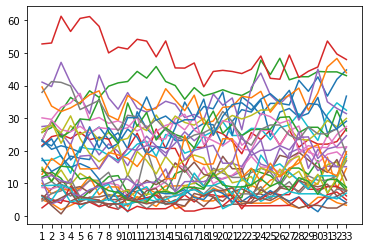

In [22]:
for num_ix, rand_num in enumerate(rand):
    for index_t_well, _ in tqdm.tqdm(enumerate(tot_well)):

        time_points = list(map(str, range(1,34)))

        new_time = []
        for i in time_points:
            r = '_' + i + '.'
            new_time.append(r)



        path_test = '/home/jovyan/DATA_MASTER_PROJECT/IMG_A549_high_con/{}_cropped/'.format(a)

        # NAME OF THE WELLS CORRESPONDING TO THE DRUG THAT YOU WANT IN THE TEST SET 

        wells_drug = [tot_well[index_t_well][0]] 

        test = []

        for _,_, filenames in os.walk(path_test):

            for filename in sorted(filenames, key = natural_keys):

                for w in wells_drug:
                    for t in new_time:
                        if '{}'.format(w) in filename and '{}tiff'.format(t) in filename:
                            test.append(filename)

        groups_list = ['{}'.format(a), '{}'.format(b)]

        fileds_of_view = ['1','2','3','4','5']

        field_train, field_val = train_test_split(fileds_of_view, test_size=0.2, random_state=rand_num)


        train = []

        validation = []

        group_compounds = []

        for group in tqdm.tqdm(groups_list):

            pa = '/home/jovyan/DATA_MASTER_PROJECT/IMG_A549_high_con/{}_cropped/'.format(group)

            for _,_, filenames in os.walk(pa):

                for filename in sorted(filenames, key = natural_keys):

                    for t in new_time:

                        if '_{}-'.format(wells_drug[0]) not in filename  and '{}tiff'.format(t) in filename:

                            group_compounds.append(filename)






        for i in group_compounds:

            for f in field_train:
                if '-{}_'.format(f) in i:
                    train.append(i)


            for v in field_val:
                if '-{}_'.format(v) in i:
                    validation.append(i)


        x_train = loadImages(train)
        y_train = make_labels(train)



        x_val = loadImages(validation)
        y_val = make_labels(validation)



        x_train = resize(x_train)


        x_val = resize(x_val)


        weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)


        x_train = preprocess_input(x_train)

        x_val = preprocess_input(x_val)


        es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

        pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

        base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

        batch_size = 128

        datagen = ImageDataGenerator()

        datagen.fit(x_train)

        train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

        dat_val = ImageDataGenerator()

        dat_val.fit(x_val)

        val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

        m4 = Sequential()
        m4.add(base_model)


        m4.add(BatchNormalization())
        m4.add(GlobalAveragePooling2D())
        m4.add(Dense(64, activation='relu'))
        m4.add(BatchNormalization())
        m4.add(Activation('relu'))
        m4.add(Dense(1,activation='sigmoid'))


        base_model.trainable = False

        opt = keras.optimizers.Adam(lr=1e-4)

        m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])



        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = (val_gen), 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                         verbose = 1)

        base_model.trainable = True

        opt = keras.optimizers.Adam(lr=1e-5)

        m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)//batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = val_gen, 
                        validation_steps = (len(x_val)//batch_size),
                        class_weight = weights,
                        verbose = 1)

        l = []
        for t in new_time:
            for i in test:
                if t in i:
                    l.append((i))


        grouped = {}
        for elem in l:
            key = elem.split('.tiff')[0].split('_')[5]
            grouped.setdefault(key, []).append(elem)
        grouped = grouped.values()

        test_data = list(grouped)

        r = []

        for ix ,_ in enumerate(test_data):
            r.append(time_step_acc(test_data[ix],m4))

        plt.plot(time_points,r)
        plt.savefig('/home/jovyan/IMG_CNN_FINAL/{}_accuracy.png'.format(string_well[index_t_well]))

        tot_results_accuracy.append(r)
        
        for i, layer in enumerate(m4.layers):
            layer._name = 'layer_' + str(i)



        lstm_model = Model(inputs=m4.input, outputs=m4.get_layer('layer_4').output)

        del m4
        K.clear_session()
        
        data_name = [train,test,validation]

        feat_name = ['train', 'test', 'validation']

        for index_name, _ in enumerate(data_name):

            path =  data_name[index_name]

            name_well = []

            for i in path:
                name_well.append(i.split('_id')[0])

            wells = list(set(name_well))
            wells

            for w in wells:

                time = []


                for filename in sorted(path, key = natural_keys):
                    if w in filename: #PAY ATTENTION ID THE IMAGE IS A TIFF OR PNG IMAGE #########
                        time.append(filename)

                data_id = {}
                n_id = []
                w_n = []

                for i in time:
                    t = i.split('_id_')[1].split('time_')[0]
                    f = i.split('_id_')[0].split('time_')[0]
                    n_id.append(t)
                    w_n.append(f)

                id_cell = set(n_id)


                for ix, i in enumerate(sorted(id_cell, key = natural_keys)):

                    id_name = []
                    dict_1 = {}

                    for t in time:
                        if 'id_{}'.format(i) in t:
                            id_name.append(t)

                    d = {'id':id_name}
                    data = pd.DataFrame(d)

                    dict_1[ix]=data 
                    data_id.update(dict_1) 

                delete = [i for i, j in data_id.items() if len(j) < len(time_points)] # 9 or the length of time span you are traning on 
                for i in delete : del data_id[i]

                len_id = [i for i, j in data_id.items()]

                for le in len_id:    


                    e = pd.DataFrame(data_id[le])

                    coords = e.values.tolist()
                    id_cells = []
                    for i in coords:
                        for j in i:
                            id_cells.append(j)

                    x_orig = loadImages(id_cells)
                    x_orig = resize(x_orig)

                    x_orig = preprocess_input(x_orig)
                    output = lstm_model.predict(x_orig)
                    np.save('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_{}/features_well_{}_id_{}.npy'.format(feat_name[index_name],w_n[0], le), output)
            print('Saved_feature_{}'.format(feat_name[index_name]))


        x_train_lstm = loadImages_LSTM(train_data, len(time_points))
        y_train_lstm = make_labels_LSTM(y_tra_path)

        x_test_lstm = loadImages_LSTM(tes_data, len(time_points))
        y_test_lstm = make_labels_LSTM(y_tes_path)

        x_val_lstm = loadImages_LSTM(val_data, len(time_points))
        y_val_lstm = make_labels_LSTM(y_val_path)

        weights_lstm = class_weight.compute_class_weight('balanced', np.unique(y_train_lstm),y_train_lstm)


        m = Sequential()
        m.add(LSTM(32, input_shape = (x_train_lstm.shape[1],x_train_lstm.shape[2])))
        m.add(Dropout(0.2))
        m.add(Dense(1, activation='sigmoid'))


        opt_lstm = keras.optimizers.Adam(lr=1e-4)

        m.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m_h = m.fit(x_train_lstm,y_train_lstm,

                         callbacks = [es],

                        epochs=epochs,
                        validation_data = (x_val_lstm,y_val_lstm), 

                        class_weight = weights_lstm)


        scores_lstm = m.evaluate(x_test_lstm, y_test_lstm)
        results_lstm.append([scores_lstm[1]*100, string_well[index_t_well]])
        
        del m
        K.clear_session()

        # DELITE FILES IN FEATURE VECTOR FOLDERS

        folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/*')

        for fo in folders:
            file = glob.glob(f'{fo}/*')
            for f in file:
                os.remove(f)

In [23]:
# ACCURACY SCORE AVERAGE FOR CNN
cv_s = cv_mean_acc(tot_results_accuracy, string_well)
cv_s

[(12.596109675977267, 'met'),
 (20.925566591698715, 'mid'),
 (4.604548338160973, 'oxy'),
 (23.373184714353442, 'nap'),
 (9.424938541846444, 'dip'),
 (26.502241235640312, 'met_1'),
 (6.473505312595705, 'lab'),
 (6.726360983789117, 'car'),
 (21.309260817037686, 'mep'),
 (36.21095849408044, 'nef'),
 (24.125018911530276, 'tri'),
 (25.047500642261117, 'dox')]

In [24]:
cv_s_mean,_ = zip(*cv_s)

m_cv = np.mean(list(cv_s_mean))
m_cv    

18.109932854914295

In [25]:
# PLOT OF MEAN ACCURACY FOR EVERY TIME POINT CNN

l_drug = string_well*3

acc_plot = []

for i in tot_results_accuracy:
    acc_plot.append(i)

cv_plot = list(zip(acc_plot, l_drug))

res_plot = sorted(cv_plot, key = lambda x: x[1])

a , b = zip(*res_plot)
    
a = list(a)

s = list(np.array_split(a, len(string_well)))

cv_plot = []

for ix, i in enumerate(s):
    s1 = list(s[ix])
    
    cv_plot.append(np.average(s1, axis=0))

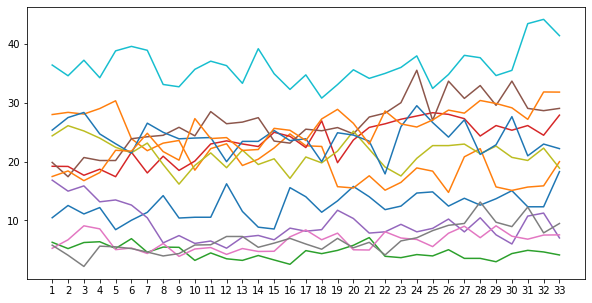

In [26]:
fig = plt.figure(figsize=(10, 5))
for i in cv_plot:
    
    plt.plot(time_points, i)
    plt.show
    plt.savefig('/home/jovyan/IMG_CNN_FINAL/cv_score.png')

In [27]:
results_lstm = sorted(results_lstm, key=lambda x: x[1])
r_lstm , _ = zip(*results_lstm)
    
r_lstm = list(r_lstm)

re_lstm = list(np.array_split(r_lstm, len(string_well)))

cv_lstm = []

for ix, i in enumerate(re_lstm):
    r1 = list(re_lstm[ix])
    cv_lstm.append(np.mean(r1))


In [28]:
cv_lstm = list(zip(cv_lstm, string_well))
cv_lstm

[(9.595959881941477, 'met'),
 (11.244979500770569, 'mid'),
 (6.722689233720303, 'oxy'),
 (28.746178249518078, 'nap'),
 (2.158273415019115, 'dip'),
 (24.796747664610546, 'met_1'),
 (7.377049078543981, 'lab'),
 (5.376343925793965, 'car'),
 (8.943089346090952, 'mep'),
 (19.114219148953755, 'nef'),
 (12.027491132418314, 'tri'),
 (12.030075490474701, 'dox')]

In [29]:
cv_l_mean,_ = zip(*cv_lstm)

m_cv_l = np.mean(list(cv_l_mean))
m_cv_l 

12.344424672321312

In [30]:
# BEFORE RUNNING AGAIN

folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/*')

for fo in folders:
    file = glob.glob(f'{fo}/*')
    for f in file:
        os.remove(f)

In [31]:
me = np.mean(cv_plot, axis = 0)
me = me.flatten()

In [32]:
sd = np.std(cv_plot, axis = 0)
sd = sd.flatten()

In [33]:
sd_cv_l =  np.std(list(cv_l_mean))
sd_cv_l

7.632331036413319

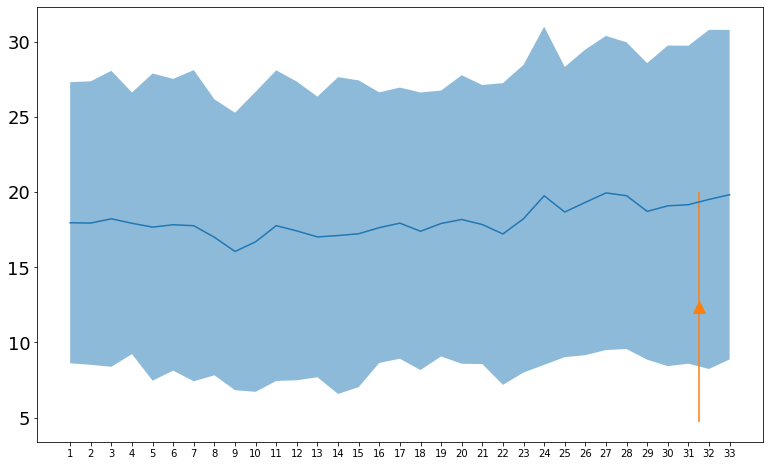

In [34]:
plt.rc('ytick', labelsize=18)
ax = plt.figure(figsize=(13,8), facecolor='w').gca()
ax.plot(me)
ax.fill_between(time_points, me - sd, me + sd, alpha = 0.5)

plt.errorbar(30.5, m_cv_l, sd_cv_l, linestyle='None', marker='^', markersize=12)

plt.savefig('/home/jovyan/md_sd_score.png')

In [35]:
cnn_stat = [i for i in cv_s_mean]
lstm_stat = [i for i in cv_l_mean]

In [36]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(cnn_stat, lstm_stat)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=11.000, p=0.028
Different distribution (reject H0)
